# Лабораторная работа №7
###  Демина Виктория Алексеевна  М80-406Б-19

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def tma(a, b, c, d):
    size = len(a)
    p, q = [], []
    p.append(-c[0] / b[0])
    q.append(d[0] / b[0])

    for i in range(1, size):
        p_tmp = -c[i] / (b[i] + a[i] * p[i - 1])
        q_tmp = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])
        p.append(p_tmp)
        q.append(q_tmp)

    x = [0 for _ in range(size)]
    x[size - 1] = q[size - 1]

    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

In [3]:
class Data:
    def __init__(self, args):
        self.a = args['a']
        self.b = args['b']
        self.c = args['c']
        self.d = args['d']
        self.lx = args['lx']
        self.ly = args['ly']
        self.f = args['f']
        self.alpha1 = args['alpha1']
        self.alpha2 = args['alpha2']
        self.beta1 = args['beta1']
        self.beta2 = args['beta2']
        self.gamma1 = args['gamma1']
        self.gamma2 = args['gamma2']
        self.delta1 = args['delta1']
        self.delta2 = args['delta2']
        self.phi11 = args['phi11']
        self.phi21 = args['phi21']
        self.phi12 = args['phi12']
        self.phi22 = args['phi22']
        self.psi = args['psi']
        self.solution = args['solution']

In [6]:
class ParabolicSolver:
    def __init__(self, args, nx, ny, T, K):
        self.data = Data(args)
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.tau = T / K
        self.x, self.y, self.t = self.prepare(nx, ny, T, K)
        self.uu = self.initalizeU(self.x, self.y, self.t)

    def getCoeffs(self, n):
        aa = np.zeros(len(n))
        bb = np.zeros(len(n))
        cc = np.zeros(len(n))
        dd = np.zeros(len(n))

        return aa, bb, cc, dd

    def computeCoeffs(self, x, y, t2, j):
        aa, bb, cc, dd = self.getCoeffs(x)
        bb[0] = self.hx * self.data.alpha2 - self.data.alpha1
        bb[-1] = self.hx * self.data.beta2 + self.data.beta1
        cc[0] = self.data.alpha1
        aa[-1] = -self.data.beta1
        dd[0] = self.data.phi11(y[j], t2) * self.hx
        dd[-1] = self.data.phi12(y[j], t2) * self.hx

        return aa, bb, cc, dd

    def prepare(self, nx, ny, T, K):
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.tau = T / K
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)
        t = np.arange(0, T + self.tau, self.tau)

        return x, y, t

    def initalizeU(self, x, y, t):
        u = np.zeros((len(x), len(y), len(t)))
        for i in range(len(x)):
            for j in range(len(y)):
                u[i][j][0] = self.data.psi(x[i], y[j])

        return u

    def analyticSolve(self, nx, ny, T, K):
        x, y, t = self.prepare(nx, ny, T, K)

        uu = np.zeros((len(x), len(y), len(t)))

        for i in range(len(x)):
            for j in range(len(y)):
                for k in range(len(t)):
                    uu[i][j][k] = self.data.solution(x[i], y[j], t[k])

        return uu

    def parallelDirections_solver(self):
        for k in range(1, len(self.t)):
            u1 = np.zeros((len(self.x), len(self.y)))
            t2 = self.t[k] - self.tau / 2
            for j in range(len(self.y) - 1):
                aa, bb, cc, dd = self.computeCoeffs(self.x, self.y, t2, j)
                for i in range(len(self.x) - 1):
                    aa[i] = self.data.a - self.hx * self.data.c / 2
                    bb[i] = self.hx ** 2 - 2 * (self.hx ** 2) / self.tau - 2 * self.data.a
                    cc[i] = self.data.a + self.hx * self.data.c / 2
                    dd[i] = -2 * (self.hx ** 2) * self.uu[i][j][k - 1] / self.tau
                    - self.data.b * (self.hx ** 2) * (self.uu[i][j + 1][k - 1]
                                                      - 2 * self.uu[i][j][k - 1] + self.uu[i][j - 1][k - 1]) / (self.hy ** 2)
                    - self.data.d * (self.hx ** 2) * (self.uu[i][j + 1][k - 1] - self.uu[i][j - 1][k - 1]) / (2 * self.hy ** 2)
                    - (self.hx ** 2) * self.data.f(self.x[i], self.y[j], self.t[k])

                xx = tma(aa, bb, cc, dd)
                for i in range(len(self.x)):
                    u1[i][j] = xx[i]
                    u1[i][0] = (self.data.phi21(self.x[i], t2) - self.data.gamma1 * u1[i][1] / self.hy) / (
                            self.data.gamma2 - self.data.gamma1 / self.hy)
                    u1[i][-1] = (self.data.phi22(self.x[i], t2) + self.data.delta1 * u1[i][-2] / self.hy) / (
                            self.data.delta2 + self.data.delta1 / self.hy)
            for j in range(len(self.y)):
                u1[0][j] = (self.data.phi11(self.y[j], t2) - self.data.alpha1 * u1[1][j] / self.hx) / (
                            self.data.alpha2 - self.data.alpha1 / self.hx)
                u1[-1][j] = (self.data.phi12(self.y[j], t2) + self.data.beta1 * u1[-2][j] / self.hx) / (
                            self.data.beta2 + self.data.beta1 / self.hx)
            u2 = np.zeros((len(self.x), len(self.y)))
            for i in range(len(self.x) - 1):
                aa, bb, cc, dd = self.getCoeffs(self.y)
                bb[0] = self.hy * self.data.gamma2 - self.data.gamma1
                bb[-1] = self.hy * self.data.delta2 + self.data.delta1
                cc[0] = self.data.gamma1
                aa[-1] = -self.data.delta1
                dd[0] = self.data.phi21(self.x[i], self.t[k]) * self.hy
                dd[-1] = self.data.phi22(self.x[i], self.t[k]) * self.hy

                for j in range(len(self.y) - 1):
                    aa[j] = self.data.b - self.hy * self.data.d / 2
                    bb[j] = self.hy ** 2 - 2 * (self.hy ** 2) / self.tau - 2 * self.data.b
                    cc[j] = self.data.b + self.hy * self.data.d / 2
                    dd[j] = -2 * (self.hy ** 2) * u1[i][j] / self.tau
                    - self.data.a * (self.hy ** 2) * (u1[i + 1][j]
                                                      - 2 * u1[i][j] + u1[i - 1][j]) / (self.hx ** 2)
                    - self.data.c * (self.hy ** 2) * (u1[i + 1][j] - u1[i - 1][j]) / (2 * self.hx ** 2)
                    - (self.hy ** 2) * self.data.f(self.x[i], self.y[j], self.t[k])
                xx = tma(aa, bb, cc, dd)
                for j in range(len(self.y)):
                    u2[i][j] = xx[j]
                    u2[0][j] = (self.data.phi11(self.y[j], self.t[k]) - self.data.alpha1 * u2[1][j] / self.hx) / (
                                self.data.alpha2 - self.data.alpha1 / self.hx)
                    u2[-1][j] = (self.data.phi12(self.y[j], self.t[k]) + self.data.beta1 * u2[-2][j] / self.hx) / (
                                self.data.beta2 + self.data.beta1 / self.hx)
            for i in range(len(self.x)):
                u2[i][0] = (self.data.phi21(self.x[i], self.t[k]) - self.data.gamma1 * u2[i][1] / self.hy) / (
                            self.data.gamma2 - self.data.gamma1 / self.hy)
                u2[i][-1] = (self.data.phi22(self.x[i], self.t[k]) + self.data.delta1 * u2[i][-2] / self.hy) / (
                            self.data.delta2 + self.data.delta1 / self.hy)
            for i in range(len(self.x)):
                for j in range(len(self.y)):
                    self.uu[i][j][k] = u2[i][j]
        return self.uu

    def fractionalSteps_solver(self):
        for k in range(len(self.t)):
            u1 = np.zeros((len(self.x), len(self.y)))
            t2 = self.t[k] - self.tau / 2
            for j in range(len(self.y) - 1):
                aa, bb, cc, dd = self.computeCoeffs(self.x, self.y, t2, j)
                for i in range(len(self.x) - 1):
                    aa[i] = self.data.a
                    bb[i] = -(self.hx ** 2) / self.tau - 2 * self.data.a
                    cc[i] = self.data.a
                    dd[i] = -(self.hx ** 2) * self.uu[i][j][k - 1] / self.tau - (self.hx ** 2) * self.data.f(self.x[i], self.y[j],
                                                                                                        t2) / 2
                xx = tma(aa, bb, cc, dd)
                for i in range(len(self.x)):
                    u1[i][j] = xx[i]
                    u1[i][0] = (self.data.phi21(self.x[i], t2) - self.data.gamma1 * u1[i][1] / self.hy) / (
                            self.data.gamma2 - self.data.gamma1 / self.hy)
                    u1[i][-1] = (self.data.phi22(self.x[i], t2) + self.data.delta1 * u1[i][-2] / self.hy) / (
                            self.data.delta2 + self.data.delta1 / self.hy)
            for j in range(len(self.y)):
                u1[0][j] = (self.data.phi11(self.y[j], t2) - self.data.alpha1 * u1[1][j] / self.hx) / (
                        self.data.alpha2 - self.data.alpha1 / self.hx)
                u1[-1][j] = (self.data.phi12(self.y[j], t2) + self.data.beta1 * u1[-2][j] / self.hx) / (
                        self.data.beta2 + self.data.beta1 / self.hx)
            #####
            u2 = np.zeros((len(self.x), len(self.y)))
            for i in range(len(self.x) - 1):
                aa, bb, cc, dd = self.getCoeffs(self.y)
                bb[0] = self.hy * self.data.gamma2 - self.data.gamma1
                bb[-1] = self.hy * self.data.delta2 + self.data.delta1
                cc[0] = self.data.gamma1
                aa[-1] = -self.data.delta1
                dd[0] = self.data.phi21(self.x[i], self.t[k]) * self.hy
                dd[-1] = self.data.phi22(self.x[i], self.t[k]) * self.hy

                for j in range(len(self.y) - 1):
                    aa[j] = self.data.b
                    bb[j] = -(self.hy ** 2) / self.tau - 2 * self.data.b
                    cc[j] = self.data.b
                    dd[j] = -(self.hy ** 2) * u1[i][j] / self.tau - (self.hy ** 2) * self.data.f(self.x[i], self.y[j], self.t[k]) / 2
                xx = tma(aa, bb, cc, dd)
                for j in range(len(self.y)):
                    u2[i][j] = xx[j]
                    u2[0][j] = (self.data.phi11(self.y[j], self.t[k]) - self.data.alpha1 * u2[1][j] / self.hx) / (
                            self.data.alpha2 - self.data.alpha1 / self.hx)
                    u2[-1][j] = (self.data.phi12(self.y[j], self.t[k]) + self.data.beta1 * u2[-2][j] / self.hx) / (
                            self.data.beta2 + self.data.beta1 / self.hx)
            for i in range(len(self.x)):
                u2[i][0] = (self.data.phi21(self.x[i], self.t[k]) - self.data.gamma1 * u2[i][1] / self.hy) / (
                        self.data.gamma2 - self.data.gamma1 / self.hy)
                u2[i][-1] = (self.data.phi22(self.x[i], self.t[k]) + self.data.delta1 * u2[i][-2] / self.hy) / (
                        self.data.delta2 + self.data.delta1 / self.hy)
            for i in range(len(self.x)):
                for j in range(len(self.y)):
                    self.uu[i][j][k] = u2[i][j]
        return self.uu


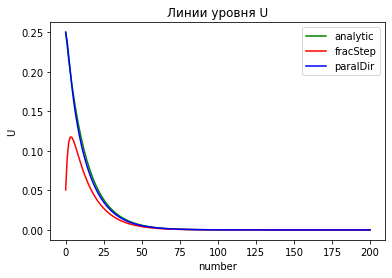

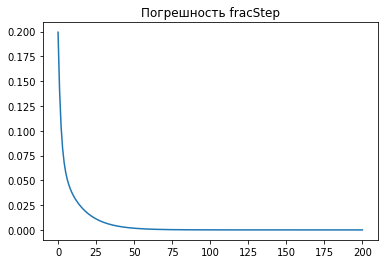

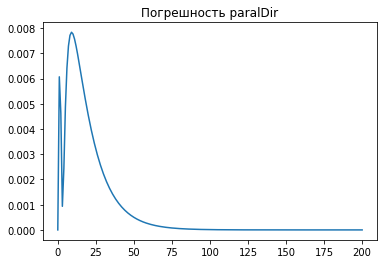

In [7]:
def presontation(dict_, data, args, y_point, time):

  plt.title('Линии уровня U')
  plt.plot(dict_['analytic'][time][y_point], color='g', label='analytic')
  plt.plot(dict_['fracStep'][time][y_point], color='r', label='fracStep')
  plt.plot(dict_['paralDir'][time][y_point], color='b', label='paralDir')
  plt.legend(loc='best')
  plt.ylabel('U')
  plt.xlabel('number')
  plt.show()


  plt.title('Погрешность fracStep')
  plt.plot(abs(dict_['analytic'][time][y_point] - dict_['fracStep'][time][y_point]))
  plt.show()


  plt.title('Погрешность paralDir')
  plt.plot(abs(dict_['analytic'][time][y_point] - dict_['paralDir'][time][y_point]))
  plt.show()


data = {'a': 1, 'nx': 40, 'ny': 40, 'T': 5, 'K': 200}
a, nx, ny, T, K = int(data['a']), int(data['nx']), int(data['ny']), int(data['T']), int(data['K'])
args = {
    'a': a,
    'b': a,
    'c': 0,
    'd': 0,
    'lx': np.pi / 4,
    'ly': np.log(2),
    'f': lambda x, y, t: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 1,
    'beta2': 0,
    'gamma1': 1,
    'gamma2': 0,
    'delta1': 0,
    'delta2': 1,
    'phi11': lambda y, t: np.sinh(y) * np.exp(-3 * a * t),
    'phi12': lambda y, t: -2 * np.sinh(y) * np.exp(-3 * a * t),
    'phi21': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t),
    'phi22': lambda x, t: 3 / 4 * np.cos(2 * x) * np.exp(-3 * a * t),
    'psi': lambda x, y: np.cos(2 * x) * np.sinh(y),
    'solution': lambda x, y, t: np.cos(2 * x) * np.sinh(y) * np.exp(-3 * a * t)
}

solver = ParabolicSolver(args, nx, ny, T, K)
solverFrac = ParabolicSolver(args, nx, ny, T, K)
solverParal = ParabolicSolver(args, nx, ny, T, K)
ans = {
    'fracStep': solverFrac.fractionalSteps_solver(),
    'paralDir': solverParal.parallelDirections_solver(),
    'analytic': solver.analyticSolve(nx, ny, T, K)
}

presontation(ans, data, args, 20, 20)

## Исследование зависимости погрешности от параметров tau, hx, hy

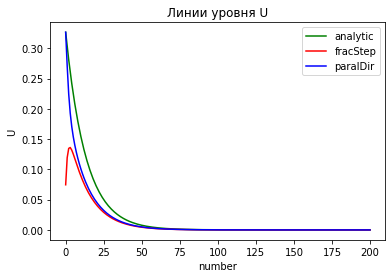

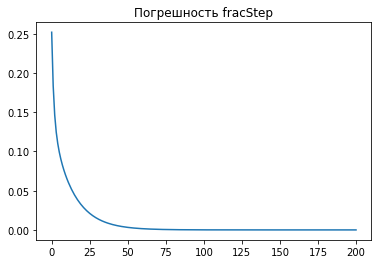

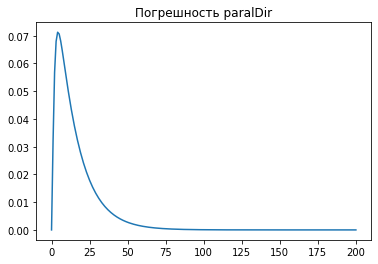

In [6]:
data = {'a': 1, 'nx': 80, 'ny': 40, 'T': 5, 'K': 200}
a, nx, ny, T, K = int(data['a']), int(data['nx']), int(data['ny']), int(data['T']), int(data['K'])
args = {
	'a': a,
	'b': a,
	'c': 0,
	'd': 0,
	'lx': np.pi / 4,
	'ly': np.log(2),
	'f': lambda x, y, t: 0,
	'alpha1': 0,
	'alpha2': 1,
	'beta1': 1,
	'beta2': 0,
	'gamma1': 1,
	'gamma2': 0,
	'delta1': 0,
	'delta2': 1,
	'phi11': lambda y, t: np.sinh(y) * np.exp(-3 * a * t),
	'phi12': lambda y, t: -2 * np.sinh(y) * np.exp(-3 * a * t),
	'phi21': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t),
	'phi22': lambda x, t: 3 / 4 * np.cos(2 * x) * np.exp(-3 * a * t),
	'psi': lambda x, y: np.cos(2 * x) * np.sinh(y),
	'solution': lambda x, y, t: np.cos(2 * x) * np.sinh(y) * np.exp(-3 * a * t)
}

solver = ParabolicSolver(args, nx, ny, T, K)
solverFrac = ParabolicSolver(args, nx, ny, T, K)
solverParal = ParabolicSolver(args, nx, ny, T, K)
ans = {
	'fracStep': solverFrac.fractionalSteps_solver(),
	'paralDir': solverParal.parallelDirections_solver(),
	'analytic': solver.analyticSolve(nx, ny, T, K)
}

presontation(ans, data, args, 20, 20)

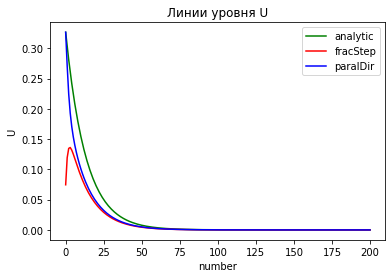

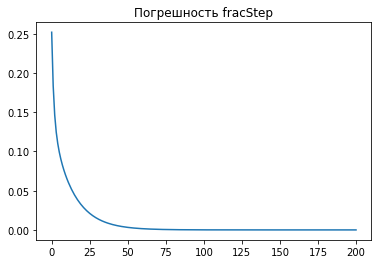

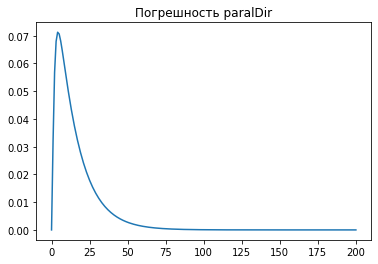

In [8]:
data = {'a': 1, 'nx': 80, 'ny': 40, 'T': 5, 'K': 200}
a, nx, ny, T, K = int(data['a']), int(data['nx']), int(data['ny']), int(data['T']), int(data['K'])
args = {
    'a': a,
    'b': a,
    'c': 0,
    'd': 0,
    'lx': np.pi / 4,
    'ly': np.log(2),
    'f': lambda x, y, t: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 1,
    'beta2': 0,
    'gamma1': 1,
    'gamma2': 0,
    'delta1': 0,
    'delta2': 1,
    'phi11': lambda y, t: np.sinh(y) * np.exp(-3 * a * t),
    'phi12': lambda y, t: -2 * np.sinh(y) * np.exp(-3 * a * t),
    'phi21': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t),
    'phi22': lambda x, t: 3 / 4 * np.cos(2 * x) * np.exp(-3 * a * t),
    'psi': lambda x, y: np.cos(2 * x) * np.sinh(y),
    'solution': lambda x, y, t: np.cos(2 * x) * np.sinh(y) * np.exp(-3 * a * t)
}

solver = ParabolicSolver(args, nx, ny, T, K)
solverFrac = ParabolicSolver(args, nx, ny, T, K)
solverParal = ParabolicSolver(args, nx, ny, T, K)
ans = {
    'fracStep': solverFrac.fractionalSteps_solver(),
    'paralDir': solverParal.parallelDirections_solver(),
    'analytic': solver.analyticSolve(nx, ny, T, K)
}

presontation(ans, data, args, 20, 20)

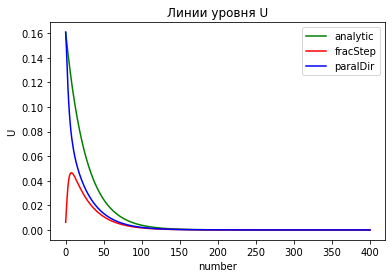

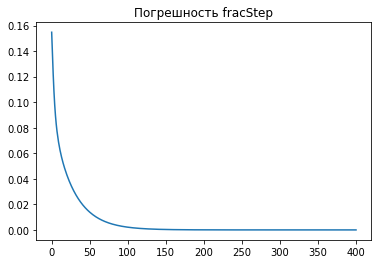

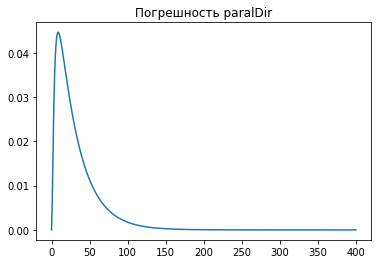

In [8]:
data = {'a': 1, 'nx': 80, 'ny': 80, 'T': 5, 'K': 400}
a, nx, ny, T, K = int(data['a']), int(data['nx']), int(data['ny']), int(data['T']), int(data['K'])
args = {
	'a': a,
	'b': a,
	'c': 0,
	'd': 0,
	'lx': np.pi / 4,
	'ly': np.log(2),
	'f': lambda x, y, t: 0,
	'alpha1': 0,
	'alpha2': 1,
	'beta1': 1,
	'beta2': 0,
	'gamma1': 1,
	'gamma2': 0,
	'delta1': 0,
	'delta2': 1,
	'phi11': lambda y, t: np.sinh(y) * np.exp(-3 * a * t),
	'phi12': lambda y, t: -2 * np.sinh(y) * np.exp(-3 * a * t),
	'phi21': lambda x, t: np.cos(2 * x) * np.exp(-3 * a * t),
	'phi22': lambda x, t: 3 / 4 * np.cos(2 * x) * np.exp(-3 * a * t),
	'psi': lambda x, y: np.cos(2 * x) * np.sinh(y),
	'solution': lambda x, y, t: np.cos(2 * x) * np.sinh(y) * np.exp(-3 * a * t)
}

solver = ParabolicSolver(args, nx, ny, T, K)
solverFrac = ParabolicSolver(args, nx, ny, T, K)
solverParal = ParabolicSolver(args, nx, ny, T, K)
ans = {
	'fracStep': solverFrac.fractionalSteps_solver(),
	'paralDir': solverParal.parallelDirections_solver(),
	'analytic': solver.analyticSolve(nx, ny, T, K)
}

presontation(ans, data, args, 20, 20)

## Выводы:
При увелечении hx и hy погрешность сначала падает, но после какого-то значения начинает расти. tau не оказывает сильного влияния на погрешность